In [45]:
from lammps import lammps
import numpy as np
lmp = lammps()
lmp.file("reax_ff_sim/ceo2_reaxff/ceo2_reaxff_bulk.lmp") # Fluorite CeO2 from https://next-gen.materialsproject.org/materials/mp-20194?chemsys=Ce-O

In [19]:
conv = 0.0433641 # eV to kcal/mol
nCeO2 = 4

# Initialize the volume
volume = lmp.get_thermo("vol")
volume_per_CeO2 = volume / nCeO2

E_CeO2 = lmp.get_thermo("pe")* conv / nCeO2
print("Energy per CeO2: ", E_CeO2)

Energy per CeO2:  -9.793358597990013


Run this cell to scale the volume up from the initial volume. Volume has to be resetted by running the first cell before running this cell or other cell again.

We cannot scale further down from this for some reason due to an error of "Too many ghost atoms"

38.456760362415984
40.47376354121244
42.56008772459216
44.716904122769854
46.94538394596018
49.24669840437794
51.6220187082378
54.072516067754435
56.59936169314263
59.203726794617005
61.88678258239239
64.64970026668341
67.4936510577048
70.41980616567129
73.42933680079754
76.5234141732983
79.70320949338829
82.96989397128225
86.32463881719475
89.7686152413407


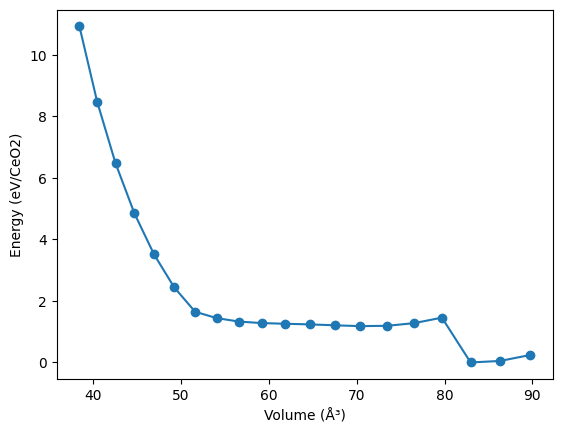

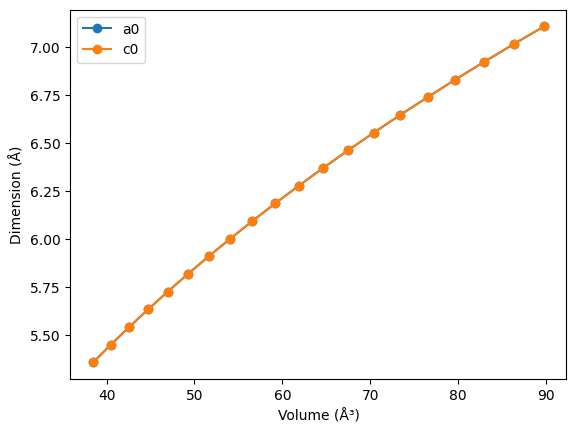

In [146]:
# Initialize a list to store the volumes and energies
volumes = []
energies = []
a0_values = []
c0_values = []

# Get the original box size
original_box = lmp.get_thermo("vol")

# Calculate the side length of the original box
original_box_dim = np.cbrt(original_box)

# Loop over a range of volumes
for scale_factor in np.linspace(0.98, 1.30, 20):  # Adjust the range and step size as needed
    # Scale the box size
    lmp.command(f"change_box all x scale {scale_factor} y scale {scale_factor} z scale {scale_factor} remap")

    # Perform energy minimization
    lmp.command("minimize 1.0e-4 1.0e-6 100 1000")

    # Get the current volume and energy
    volume = lmp.get_thermo("vol")
    energy = lmp.get_thermo("pe")  # Use the potential energy as the total energy

    volumes_per_CeO2 = volume / nCeO2
    print(volumes_per_CeO2)
    energie_per_CeO2 = energy * conv / nCeO2

    # Store the volume and energy
    volumes.append(volumes_per_CeO2)
    energies.append(energie_per_CeO2)

    a0 = lmp.get_thermo("lx")
    a0_values.append(a0)

    c0 = lmp.get_thermo("lz")
    c0_values.append(c0)

    # Reset the box size to its original value
    lmp.command(f"change_box all x final 0 {original_box_dim} y final 0 {original_box_dim} z final 0 {original_box_dim} remap")

    if volume_per_CeO2 > 80:
        break

# Convert the lists to numpy arrays
volumes = np.array(volumes)
energies = np.array(energies)
a0_values = np.array(a0_values)
c0_values = np.array(c0_values)

# Shift the energy scale so that the minimum energy is at 0 eV/CeO2
energies -= energies.min()

# Plot the energy-volume relationship
import matplotlib.pyplot as plt
plt.plot(volumes, energies, 'o-')
plt.xlabel('Volume (Å³)')
plt.ylabel('Energy (eV/CeO2)')
plt.show()

# Plot the a0 and c0 values
plt.figure()
plt.plot(volumes, a0_values, 'o-', label='a0')
plt.plot(volumes, c0_values, 'o-', label='c0')
plt.xlabel('Volume (Å³)')
plt.ylabel('Dimension (Å)')
plt.legend()
plt.show()

Create rutile structure. This cell has gone awry. The energy exploded and the lattice constant becomes way off

In [151]:
from ase import Atoms
from ase.build import bulk, make_supercell
import numpy as np

# Define lattice parameters for rutile CeO2
a = 5.078  # Angstrom
c = 3.567  # Angstrom

# Create the basic CeO2 unit cell
rutile_CeO2 = Atoms(
    symbols='Ce2O4',
    positions=[
        [0.0000, 0.0000, 0.0000],      # Ce
        [0.5000, 0.5000, 0.5000],      # Ce
        [0.3050, 0.3050, 0.0000],      # O
        [0.6950, 0.6950, 0.0000],      # O
        [0.8050, 0.1950, 0.5000],      # O
        [0.1950, 0.8050, 0.5000]       # O
    ],
    cell=[
        [a, 0, 0],
        [0, a, 0],
        [0, 0, c]
    ],
    pbc=True
)

# Add charges to each atom
# Ce atoms get +4 charge, O atoms get -2 charge
charges = [4, 4, -2, -2, -2, -2]
rutile_CeO2.set_initial_charges(charges)

# Print the initial structure with charges
print(rutile_CeO2)
print("Charges:", rutile_CeO2.get_initial_charges())

# Optionally create a supercell to see a larger structure
# Define the transformation matrix for supercell (e.g., 2x2x2)
transformation_matrix = np.diag([2, 2, 2])
supercell = make_supercell(rutile_CeO2, transformation_matrix)

# Print the supercell structure with charges
print(supercell)
print("Charges in supercell:", supercell.get_initial_charges())

# Save the structure to a file (optional)
supercell.write('CeO2_rutile_supercell.xyz')

def add_charges_to_lammps_data(input_file, output_file):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    with open(output_file, 'w') as file:
        atom_section = False
        for line in lines:
            if line.strip().startswith('Atoms'):
                atom_section = True
                file.write(line)
                file.write("\n# AtomID AtomType Charge x y z\n")
            elif atom_section and line.strip() == "":
                atom_section = False
                file.write(line)
            elif atom_section and line.strip()[0].isdigit():
                parts = line.split()
                atom_id = int(parts[0])
                atom_type = int(parts[1])
                x, y, z = parts[2], parts[3], parts[4]
                charge = 4.0 if atom_type == 1 else -2.0
                file.write(f"{atom_id} {atom_type} {charge} {x} {y} {z}\n")
            else:
                file.write(line)

# Usage
add_charges_to_lammps_data('CeO2_rutile_supercell.lmp', 'CeO2_rutile_supercell_with_charges.lmp')


Atoms(symbols='Ce2O4', pbc=True, cell=[5.078, 5.078, 3.567], initial_charges=...)
Charges: [ 4.  4. -2. -2. -2. -2.]
Atoms(symbols='Ce2O4Ce2O4Ce2O4Ce2O4Ce2O4Ce2O4Ce2O4Ce2O4', pbc=True, cell=[10.156, 10.156, 7.134], initial_charges=...)
Charges in supercell: [ 4.  4. -2. -2. -2. -2.  4.  4. -2. -2. -2. -2.  4.  4. -2. -2. -2. -2.
  4.  4. -2. -2. -2. -2.  4.  4. -2. -2. -2. -2.  4.  4. -2. -2. -2. -2.
  4.  4. -2. -2. -2. -2.  4.  4. -2. -2. -2. -2.]


Perform NVE on Ce2O3 on a structure I found from material project (according to Gunjana's recommendation). Calculate the lattice constants and also the energy per formula unit. The lattice constants are similar to that of the literature, with the exception of c_0 which is more in tandem with the information of the geometry file I downloaded from https://next-gen.materialsproject.org/materials/mp-561149?formula=Ce2O3

In [44]:
lmp.file("reax_ff_sim/ceo2_reaxff/ce2o3_reaxff_bulk.lmp")
a_0 =  lmp.get_thermo("lx")
c_0 =  lmp.get_thermo("lz")
print("Lattice constant a_0 = ", a_0)
print("Lattice constant c_0 = ", c_0)
E_Ce2O3 = lmp.get_thermo("pe") * conv / 1 # Since there is only one Ce2O3 unit in the simulation cell

print("Energy of Ce2O3 per unit = ", E_Ce2O3)

Lattice constant a_0 =  3.87098395
Lattice constant c_0 =  5.89577273
Energy of Ce2O3 per unit =  -19.925655168180477


Calculate energy of CeO2 -> Ce2O3 By giving
E = E(Ce2O3) + 1/2 E(O2) − 2E(CeO2) when each E is an energy per 1 unit of Ceria or Oxygen. This number is way off from the literature (2.5 eV/Ce2O3).

The geometry of O2 was retrieved from https://next-gen.materialsproject.org/materials/mp-607540?formula=O

In [42]:
lmp.file("reax_ff_sim/o2_reaxff/o2_reaxff.lmp")
E_O2 = 2 * lmp.get_thermo("pe") * conv # Since there is half O2 unit in the simulation cell
print("Energy of O2 per unit = ", E_O2)
E = E_Ce2O3 + E_O2 / 2 - E_CeO2
print("Energy CeO2 -> Ce2O3= ", E)

Energy of O2 per unit =  -0.028874936899001592
Energy CeO2 -> Ce2O3=  -10.146734038639964


Create a CeO2 (111) slab using pymatgen

In [78]:
import pymatgen as mg
from pymatgen.core.surface import SlabGenerator
from pymatgen.core.structure import Structure
from pymatgen.io.cif import CifWriter
from ase.io import read, write
from ase.build import surface, make_supercell, sort
from pymatgen.io.ase import AseAtomsAdaptor

structure = read("reax_ff_sim/ceo2_reaxff/geometry_file/CeO2_fluorite.cif")

slab = surface(structure, (1,1,1), layers=7, vacuum=10.0)
slab.center(vacuum=15.0, axis=2)

# Create the supercell
supercell = make_supercell(slab, [[4,0,0],[0,4,0],[0,0,1]])
write('reax_ff_sim/ceo2_slab_reaxff/geometry_files/111slab.cif', slab, format='cif')


The center of the surface is at (5.937180799510274, 2.6838071799635537, 25.52211310451138)


Add charges to the lammps file

In [74]:
# Define the charges for each atom type
atom_charges = {
    1: 4.0,  # Ce
    2: -2.0  # O
}

# Read the file and store its contents
with open("reax_ff_sim/ceo2_slab_reaxff/geometry_files/111slab.lmp", "r") as file:
    lines = file.readlines()

# Find the line number where atom information starts
atom_info_line = None
for i, line in enumerate(lines):
    if line.strip().startswith("Atoms"):
        atom_info_line = i + 1
        break

# If the line number is found, add charges to each atom
if atom_info_line is not None:
    # Iterate through atom lines and add charges
    for i in range(atom_info_line, len(lines)):
        atom_line = lines[i].split()
        if len(atom_line) < 2:
            continue  # Skip lines that do not have enough elements
        atom_index = atom_line[0]
        atom_type = int(atom_line[1])
        charge = atom_charges.get(atom_type)
        if charge is not None:
            # Modify the line to include charge
            lines[i] = "         " + atom_line[0] + "         " + atom_line[1] + "   " + str(charge) +  "        " + atom_line[2] + "       " + atom_line[3] + "       " + atom_line[4] + "\n"

# Write the modified contents back to the file
with open("reax_ff_sim/ceo2_slab_reaxff/geometry_files/111slab_with_charges.lmp", "w") as file:
    file.writelines(lines)

print("Charges have been added to the atom entries in the file.")

Charges have been added to the atom entries in the file.


Run energy minimization on the slab to get E[CeO2 slab]

In [75]:
lmp.file("reax_ff_sim/ceo2_slab_reaxff/ceo2_slab_reaxff.lmp")   # Run the simulation
E_slab = lmp.get_thermo("pe") * conv / 1
print(E_slab)

-557.1132591039097


FInd the position of oxygen to form a vacancy

In [101]:
# Get the positions of all the atoms
positions = slab.get_positions()

# Calculate the average x, y, and z coordinates to move the O above the slab at the center of the vacuum region
center_x = np.mean(positions[:, 0])
center_y = np.mean(positions[:, 1])
center_z = np.mean(positions[:, 2])

print(f"Center of the slab: ({center_x}, {center_y}, {center_z})")

center = np.array([center_x, center_y, center_z])


# Initialize the minimum distance and the index of the closest oxygen atom
min_distance = np.inf
closest_oxygen_index = None

# Get the symbols of all the atoms
symbols = slab.get_chemical_symbols()

# Iterate over all the atoms
for i, (position, symbol) in enumerate(zip(positions, symbols)):
    # If the atom is an oxygen atom
    if symbol == 'O':
        # Calculate the distance to the center
        distance = np.linalg.norm(position - center)
        
        # If the distance is smaller than the current minimum distance
        if distance < min_distance:
            # Update the minimum distance and the index of the closest oxygen atom
            min_distance = distance
            closest_oxygen_index = i

print(f"The closest oxygen atom to the center is atom number {closest_oxygen_index + 1}.")

Center of the slab: (5.937180799510274, 2.6838071799635537, 25.52211310451138)
The closest oxygen atom to the center is atom number 45.


Manually add 40 Angstrom to atom number 45 which is O29 in file called "ceo2_slab_vacancy_reaxff.lmp"  and run the simulation.From VESTA, I locate that Cerium atoms around O29 are Ce20 (Atom: 52), Ce19(Atom: 51), Ce17(Atom: 49), Ce14(Atom: 38)

In [92]:
lmp.file("reax_ff_sim/ceo2_slab_reaxff/ceo2_slab_vacancy_reaxff.lmp")   # Run the simulation
E_slab_vacancy = lmp.get_thermo("pe") * conv
print(E_slab_vacancy)

-556.4577986029554


Calculate E_vac

In [93]:
D_e_O2 = 5.45 # Dissociation energy of O2 molecule from literature in eV
E_vac = E_slab_vacancy - E_slab - D_e_O2 / 2
print("Vacancy formation energy = ", E_vac)

Vacancy formation energy =  -2.069539499045709


In [103]:
import numpy as np

# Define the cerium atoms read from final_geometry.lmp manually
Ce38 = np.array([8.115840566928172, 4.6844698250511225, 22.63357146064335])
Ce49 = np.array([8.757726578360327, 5.056750053929912, 32.48911194474918])
Ce51 = np.array([4.976228461998252, 5.461562144673321, 30.439949401398746])
Ce52 = np.array([7.217759157468515, 1.579273895293887, 30.43947116633558])

# Create a list of the points considering how Ce is labeled in the literature
points = [Ce38, Ce49, Ce51, Ce52]

# Define the pairs of points for which to calculate distances
pairs = [(1, 3), (2, 4), (1, 2), (2, 3), (3, 4)]

# Calculate the distances between the specified pairs of points
for pair in pairs:
    dist = np.linalg.norm(points[pair[0]-1] - points[pair[1]-1])
    print(f"The distance between point {pair[0]} and point {pair[1]} is {dist} Angstrom.")

The distance between point 1 and point 3 is 8.449885987192417 units.
The distance between point 2 and point 4 is 4.320343436791347 units.
The distance between point 1 and point 2 is 9.883435053377717 units.
The distance between point 2 and point 3 is 4.320031014001219 units.
The distance between point 3 and point 4 is 4.482925622705981 units.
